<a href="https://colab.research.google.com/github/megalphian/learning_rl/blob/main/diffusion_policy/Diffusion_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install denoising_diffusion_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0.0

class RRTStar:
    def __init__(self, start, goal, obstacles, x_bounds, y_bounds, max_iter, step_size, neighbor_radius):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.obstacles = obstacles
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds
        self.max_iter = max_iter
        self.step_size = step_size
        self.neighbor_radius = neighbor_radius
        self.nodes = [self.start]

    def generate_random_node(self):
        x = np.random.uniform(self.x_bounds[0], self.x_bounds[1])
        y = np.random.uniform(self.y_bounds[0], self.y_bounds[1])
        return Node(x, y)

    def distance(self, node1, node2):
        return np.sqrt((node1.x - node2.x)**2 + (node1.y - node2.y)**2)

    def steer(self, from_node, to_node):
        dist = self.distance(from_node, to_node)
        if dist < self.step_size:
            return to_node
        else:
            theta = np.arctan2(to_node.y - from_node.y, to_node.x - from_node.x)
            new_x = from_node.x + self.step_size * np.cos(theta)
            new_y = from_node.y + self.step_size * np.sin(theta)
            return Node(new_x, new_y)

    def is_collision_free(self, node1, node2):
        for obstacle in self.obstacles:
            # Simple collision checking for circles
            obs_node = Node(obstacle[0], obstacle[1])
            if self.distance(node1, obs_node) < obstacle[2] or \
               self.distance(node2, obs_node) < obstacle[2]:
                return False
            # More sophisticated line-segment to circle collision check could be added here
            # For simplicity, we'll just check the endpoints for now
        return True

    def get_neighbors(self, new_node):
        neighbors = []
        for node in self.nodes:
            if self.distance(new_node, node) < self.neighbor_radius:
                neighbors.append(node)
        return neighbors

    def choose_parent(self, new_node, neighbors):
        min_cost = float('inf')
        best_parent = None
        for neighbor in neighbors:
            if self.is_collision_free(neighbor, new_node):
                cost = neighbor.cost + self.distance(neighbor, new_node)
                if cost < min_cost:
                    min_cost = cost
                    best_parent = neighbor
        if best_parent is not None:
            new_node.parent = best_parent
            new_node.cost = min_cost
        return new_node

    def rewire(self, new_node, neighbors):
        for neighbor in neighbors:
            if neighbor.parent is not None and self.is_collision_free(new_node, neighbor):
                new_cost = new_node.cost + self.distance(new_node, neighbor)
                if new_cost < neighbor.cost:
                    neighbor.parent = new_node
                    neighbor.cost = new_cost

    def plan(self):
        for _ in range(self.max_iter):
            random_node = self.generate_random_node()
            nearest_node = min(self.nodes, key=lambda node: self.distance(node, random_node))
            new_node = self.steer(nearest_node, random_node)

            if self.is_collision_free(nearest_node, new_node):
                neighbors = self.get_neighbors(new_node)
                new_node = self.choose_parent(new_node, neighbors)
                self.rewire(new_node, neighbors)
                self.nodes.append(new_node)

                if self.distance(new_node, self.goal) < self.step_size and self.is_collision_free(new_node, self.goal):
                    self.goal.parent = new_node
                    self.goal.cost = new_node.cost + self.distance(new_node, self.goal)
                    self.nodes.append(self.goal)
                    return self.get_path()

        return None # No path found

    def get_path(self):
        path = []
        current_node = self.goal
        while current_node is not None:
            path.append((current_node.x, current_node.y))
            current_node = current_node.parent
        return path[::-1]

    def plot(self, path=None):
        plt.figure()
        # Plot obstacles (circles)
        for obstacle in self.obstacles:
            circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r')
            plt.gca().add_patch(circle)

        # Plot RRT* tree
        for node in self.nodes:
            if node.parent:
                plt.plot([node.x, node.parent.x], [node.y, node.parent.y], 'b-')

        # Plot path if found
        if path:
            path_x = [p[0] for p in path]
            path_y = [p[1] for p in path]
            plt.plot(path_x, path_y, 'g-', linewidth=2)

        # Plot start and goal
        plt.plot(self.start.x, self.start.y, 'go', markersize=10)
        plt.plot(self.goal.x, self.goal.y, 'ro', markersize=10)

        plt.xlim(self.x_bounds)
        plt.ylim(self.y_bounds)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('RRT* Path Planning')
        plt.grid(True)
        plt.show()

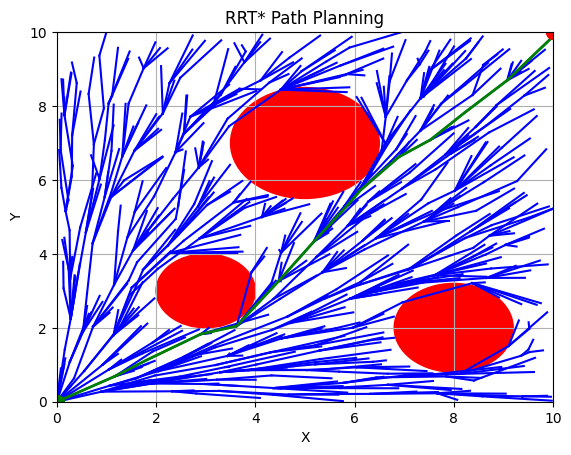

Path found!


In [ ]:
# Define the environment
start = (0, 0)
goal = (10, 10)
obstacles = [(3, 3, 1), (5, 7, 1.5), (8, 2, 1.2)]  # (x, y, radius)
x_bounds = (0, 10)
y_bounds = (0, 10)

# RRT* parameters
max_iter = 1000
step_size = 0.5
neighbor_radius = 1.5

# Generate a path
rrt_star = RRTStar(start, goal, obstacles, x_bounds, y_bounds, max_iter, step_size, neighbor_radius)
path = rrt_star.plan()

# Plot the generated path
if path:
    rrt_star.plot(path)
    print("Path found!")
else:
    print("No path found.")

In [ ]:
import numpy as np

def sample_path(path, num_samples):
    """
    Samples evenly spaced points along a path.

    Args:
        path: A list of (x, y) tuples representing the path.
        num_samples: The desired number of samples.

    Returns:
        A list of (x, y) tuples representing the sampled points.
    """
    if not path:
        return []

    path = np.array(path)
    distances = np.cumsum(np.sqrt(np.sum(np.diff(path, axis=0)**2, axis=1)))
    distances = np.insert(distances, 0, 0)
    total_distance = distances[-1]

    if total_distance == 0:
        return [path[0]] * num_samples

    sample_distances = np.linspace(0, total_distance, num_samples)
    sampled_points = []
    for sample_dist in sample_distances:
        # Find the segment where the sample point lies
        segment_index = np.searchsorted(distances, sample_dist) - 1
        segment_index = max(0, min(segment_index, len(path) - 2))

        # Interpolate between the two points of the segment
        p1 = path[segment_index]
        p2 = path[segment_index + 1]
        segment_length = distances[segment_index + 1] - distances[segment_index]

        if segment_length == 0:
            sampled_points.append(tuple(p1))
        else:
            t = (sample_dist - distances[segment_index]) / segment_length
            sampled_x = p1[0] + t * (p2[0] - p1[0])
            sampled_y = p1[1] + t * (p2[1] - p1[1])
            sampled_points.append((sampled_x, sampled_y))

    return sampled_points

# Example usage:
if path:
    num_samples = 128  # As required for the diffusion model
    sampled_trajectory = sample_path(path, num_samples)
    print(f"\nSampled trajectory with {num_samples} points:")
    # print(sampled_trajectory) # Uncomment to see the sampled points


Sampled trajectory with 128 points:


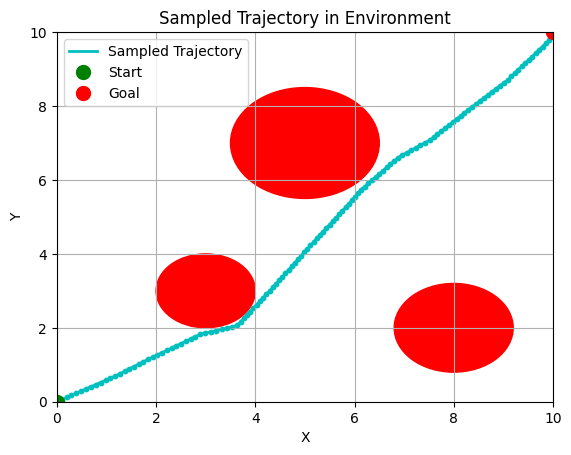

In [ ]:
# prompt: Plot the sampled trajectory in the original environment. Assume sampled_trajectory is a list of 2d points presented as tuples

import matplotlib.pyplot as plt
plt.figure()
# Plot obstacles (circles)
for obstacle in obstacles:
  circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r')
  plt.gca().add_patch(circle)

# Plot the sampled trajectory
if sampled_trajectory:
  traj_x = [p[0] for p in sampled_trajectory]
  traj_y = [p[1] for p in sampled_trajectory]
  plt.plot(traj_x, traj_y, 'c-', linewidth=2, label='Sampled Trajectory')
  plt.scatter(traj_x, traj_y, color='c', s=10) # Mark the sampled points

# Plot start and goal
plt.plot(start[0], start[1], 'go', markersize=10, label='Start')
plt.plot(goal[0], goal[1], 'ro', markersize=10, label='Goal')

plt.xlim(x_bounds)
plt.ylim(y_bounds)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sampled Trajectory in Environment')
plt.grid(True)
plt.legend()
plt.show()

# Generate a set of environments as the dataset to train diffusion on

Generated path for environment 1/100
Generated path for environment 2/100
Generated path for environment 3/100
Generated path for environment 4/100
Generated path for environment 5/100
Generated path for environment 6/100
Generated path for environment 7/100
Generated path for environment 8/100
Generated path for environment 9/100
Generated path for environment 10/100
Generated path for environment 11/100
Generated path for environment 12/100
Generated path for environment 13/100
Generated path for environment 14/100
Generated path for environment 15/100
Generated path for environment 16/100
Generated path for environment 17/100
Generated path for environment 18/100
Generated path for environment 19/100
Generated path for environment 20/100
Generated path for environment 21/100
Generated path for environment 22/100
Generated path for environment 23/100
Generated path for environment 24/100
Generated path for environment 25/100
Generated path for environment 26/100
Generated path for en

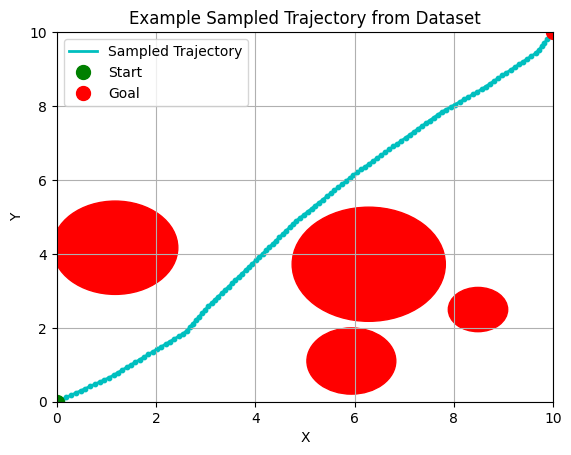

In [ ]:
# Generate multiple environments and paths
num_environments = 100
dataset = []

for i in range(num_environments):
    # Define a new environment (randomizing obstacles)
    start = (0, 0)
    goal = (10, 10)
    num_obstacles = np.random.randint(3, 6)
    obstacles = []
    for _ in range(num_obstacles):
        obs_x = np.random.uniform(1, 9)
        obs_y = np.random.uniform(1, 9)
        obs_radius = np.random.uniform(0.5, 2)
        obstacles.append((obs_x, obs_y, obs_radius))

    # RRT* parameters (can also be randomized)
    max_iter = 1500
    step_size = 0.7
    neighbor_radius = 2

    # Generate a path
    rrt_star = RRTStar(start, goal, obstacles, x_bounds, y_bounds, max_iter, step_size, neighbor_radius)
    path = rrt_star.plan()

    if path:
        # Sample the path
        num_samples = 128
        sampled_trajectory = sample_path(path, num_samples)
        dataset.append({
            'start': start,
            'goal': goal,
            'obstacles': obstacles,
            'trajectory': sampled_trajectory
        })
        print(f"Generated path for environment {i+1}/{num_environments}")
    else:
        print(f"No path found for environment {i+1}/{num_environments}")

print(f"\nGenerated dataset with {len(dataset)} trajectories.")

# Plot one example sampled trajectory from the dataset
if dataset:
    example_data = dataset[0]
    example_obstacles = example_data['obstacles']
    example_trajectory = example_data['trajectory']
    example_start = example_data['start']
    example_goal = example_data['goal']

    plt.figure()
    # Plot obstacles (circles)
    for obstacle in example_obstacles:
        circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r')
        plt.gca().add_patch(circle)

    # Plot the sampled trajectory
    traj_x = [p[0] for p in example_trajectory]
    traj_y = [p[1] for p in example_trajectory]
    plt.plot(traj_x, traj_y, 'c-', linewidth=2, label='Sampled Trajectory')
    plt.scatter(traj_x, traj_y, color='c', s=10) # Mark the sampled points

    # Plot start and goal
    plt.plot(example_start[0], example_start[1], 'go', markersize=10, label='Start')
    plt.plot(example_goal[0], example_goal[1], 'ro', markersize=10, label='Goal')

    plt.xlim(x_bounds)
    plt.ylim(y_bounds)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Example Sampled Trajectory from Dataset')
    plt.grid(True)
    plt.legend()
    plt.show()

# Run the below cells with the dataset file loaded

Train a diffusion model using the obtained trajectories.

In [3]:
import torch
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D
import pickle
import numpy as np

# Load the dataset from the pickle file
filename = 'motion_planning_dataset.pkl'
with open(filename, 'rb') as f:
    dataset = pickle.load(f)

# Extract trajectories, obstacle information, and start/goal points
trajectories = []
obstacle_data = []
start_points = []
goal_points = []

for data in dataset:
    trajectories.append(np.array(data['trajectory']).T) # Shape (2, 128)
    # Simple representation of obstacles: flatten the list of (x, y, r) tuples
    # Assuming a fixed number of obstacles or padding if the number varies
    # For now, let's assume a maximum number of obstacles and pad with zeros
    max_obstacles = 6 # Define a maximum number of obstacles, corrected to 6
    flattened_obstacles = []
    for obs in data['obstacles']:
        flattened_obstacles.extend(obs)
    # Pad with zeros if the number of obstacles is less than max_obstacles
    while len(flattened_obstacles) < max_obstacles * 3:
        flattened_obstacles.append(0.0)
    # Truncate if there are more than max_obstacles
    flattened_obstacles = flattened_obstacles[:max_obstacles * 3]
    obstacle_data.append(flattened_obstacles)

    start_points.append(list(data['start']))
    goal_points.append(list(data['goal']))


# Stack the data into numpy arrays
training_data = np.stack(trajectories, axis=0) # Shape will be (num_trajectories, 2, 128)
obstacle_data = np.array(obstacle_data) # Shape will be (num_trajectories, max_obstacles * 3)
start_points = np.array(start_points) # Shape will be (num_trajectories, 2)
goal_points = np.array(goal_points)   # Shape will be (num_trajectories, 2)


# Convert to PyTorch tensors and normalize
training_seq = torch.from_numpy(training_data).float()
# Simple normalization for trajectories to [0, 1]
training_seq = training_seq / 10.0 # Assuming coordinates are in [0, 10]

# Normalize obstacle data - you might need a more sophisticated normalization
# depending on the range of your obstacle parameters
obstacle_data = torch.from_numpy(obstacle_data).float()
# Example normalization: divide by max possible value or use mean/std
# Assuming max x, y are within the environment bounds (0-10) and max r is 2
obstacle_data[:, 0::3] /= 10.0 # Normalize x
obstacle_data[:, 1::3] /= 10.0 # Normalize y
obstacle_data[:, 2::3] /= 2.0   # Normalize radius

# Normalize start and goal points
start_points = torch.from_numpy(start_points).float() / 10.0 # Assuming coordinates are in [0, 10]
goal_points = torch.from_numpy(goal_points).float() / 10.0   # Assuming coordinates are in [0, 10]

# Create conditioning data by concatenating start, goal, and obstacle data
# The shape will be (num_trajectories, 2 + 2 + max_obstacles * 3)
conditioning_data = torch.cat((start_points, goal_points, obstacle_data), dim=1)

# Move data to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
training_seq = training_seq.to(device)
conditioning_data = conditioning_data.to(device)

print(f"Using device: {device}")

Using device: cpu


In [4]:
# Now, we need to modify the Unet1D and GaussianDiffusion1D to accept
# conditioning_data.
# This part will be done in the next steps as it requires changes to the model definitions.
# For now, we have the data loaded and preprocessed and conditioning data created.


# Keep the model and trainer initialization for reference, but they will need modification
model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 2, # Changed to 2 channels for (x, y) coordinates,
    # Need to add conditioning input here - maybe through a separate conditioning network
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 128,
    timesteps = 1000,
    sampling_timesteps = 25
    # Need to pass conditioning data here
)

diff_dataset = Dataset1D(training_seq) # This will need to include conditioning_data

trainer = Trainer1D(
    diffusion,
    dataset = diff_dataset,
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 5000,
    gradient_accumulate_every = 2,
    ema_decay = 0.995,
    amp = True,
)
trainer.train()

  0%|          | 0/5000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

training complete


In [6]:
# prompt: Save a checkpoint of the diffusion model and store it

# Specify the path to save the checkpoint
checkpoint_path = 'diffusion_model_checkpoint.pt'

# Save the model state
torch.save(trainer.model.state_dict(), checkpoint_path)

print(f"Diffusion model checkpoint saved to {checkpoint_path}")

Diffusion model checkpoint saved to diffusion_model_checkpoint.pt


In [2]:
!pip install denoising_diffusion_pytorch

Evaluating on environment with index: 0


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

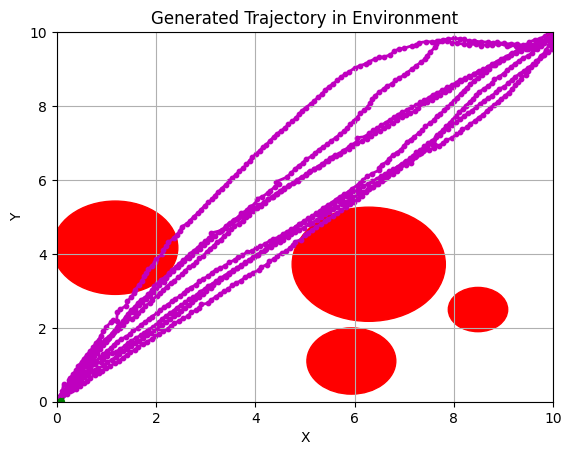

In [15]:
# Evaluate the trained diffusion model
import matplotlib.pyplot as plt
import numpy as np
import torch
import random # Import the random module


# Define environment bounds (assuming they are consistent with the training data)
x_bounds = (0, 10)
y_bounds = (0, 10)


# Select an example environment from the original dataset list for evaluation
# Assuming the original 'dataset' (list of dictionaries) is still available
if 'dataset' in locals() and dataset:
    # Set eval index to be a random value
    # eval_index = random.randint(0, len(dataset) - 1)
    eval_index = 0
    print(f"Evaluating on environment with index: {eval_index}")

    eval_data_original = dataset[eval_index]

    eval_obstacles = eval_data_original['obstacles']
    eval_start = eval_data_original['start']
    eval_goal = eval_data_original['goal']


    # Generate a trajectory using the diffusion model
    # Assuming 'diffusion' model is available after training
    if 'diffusion' in locals():
         # Generate a trajectory without conditioning data
         generated_trajectory_tensor = diffusion.sample(batch_size = 8)
         # Denormalize and transpose
         generated_trajectory = generated_trajectory_tensor.squeeze(0).detach().cpu().numpy().T * 10.0
    else:
         generated_trajectory = None
         print("Diffusion model not found. Cannot generate trajectory.")


    # Plot the generated trajectory in the environment
    plt.figure()
    # Plot obstacles (circles)
    for obstacle in eval_obstacles:
        circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r')
        plt.gca().add_patch(circle)

    # Plot start and goal
    plt.plot(eval_start[0], eval_start[1], 'go', markersize=10, label='Start')
    plt.plot(eval_goal[0], eval_goal[1], 'ro', markersize=10, label='Goal')

    # Plot the generated trajectory
    if generated_trajectory is not None and len(generated_trajectory) > 0:
        traj_x = [p[0] for p in generated_trajectory]
        traj_y = [p[1] for p in generated_trajectory]
        plt.plot(traj_x, traj_y, 'm-', linewidth=2, label='Generated Trajectory')
        plt.scatter(traj_x, traj_y, color='m', s=10) # Mark the sampled points


    plt.xlim(x_bounds)
    plt.ylim(y_bounds)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Generated Trajectory in Environment')
    plt.grid(True)
    plt.show()

else:
    print("Original dataset not found or is empty. Cannot evaluate.")